In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
from scipy.io.idl import readsav
import scipy.signal as signal
import pandas as pd

In [2]:
# load ztflc data
lc = table.Table.read('../data/ztflc_forcefit.h5')
lc

<Table length=233>
      sigma             sigma.err      ...      target_x           target_y     
     float64             float64       ...      float64            float64      
------------------ ------------------- ... ------------------ ------------------
14.472378378366585  0.4071467539468257 ...   97.4795791169883  2654.133020444947
 42.79852101731375   1.254812629594178 ... 162.38680035200477 2611.4216225853434
 5.019048789272439  0.1453871691987656 ... 139.17641139628944 2654.5798502072016
 10.72947163499287 0.30589623511701863 ... 176.83016375796797  2642.114116817149
 9.184468245595319  0.2636963406672404 ...  169.4401479698715 2665.7851881538063
10.144355640294936 0.28890516819398504 ... 141.97277464918304 2696.8115424759967
  6.79480734831998 0.18939070960168858 ... 165.77236002322067 2691.7963713021577
27.448735561223543  0.7884957167202911 ... 165.52383800425355  2612.230865263725
 7.826544860818549 0.22435069687094494 ... 151.46385748389235 2675.8265929543913
  5.14333568356807 0.14392711628327534 ... 157.16033691409172 2483.9120007313904
               ...                 ... ...                ...                ...
13.004702445429384 0.37086223104520827 ... 149.05222958082945  2655.985362217852
 7.644904310915697 0.22698969397311558 ...  121.4565883665637  2663.612826282741
 7.754619449369814 0.22235180405527463 ... 122.39632034473152 2661.2855406879685
10.157528553702546 0.28721683436054907 ... 1608.6975526442095  1830.625461010669
12.328326975949324  0.3508564506937175 ... 1640.0251051897276 1845.3641322071367
 38.67995149442595   1.130666960923682 ... 164.27927108394434 2463.6649266767117
15.083117302180508 0.43154350803086433 ... 176.48235021840125  2653.319945188249
21.702311848491192  0.6198597401396926 ... 167.49269818493036  2633.878591297881
 11.17162574053698 0.31134426347099214 ...  181.2384344781291  2671.502965566031
 4.429017756876249 0.13089623320578814 ... 112.45361030172857 2613.2088222185594

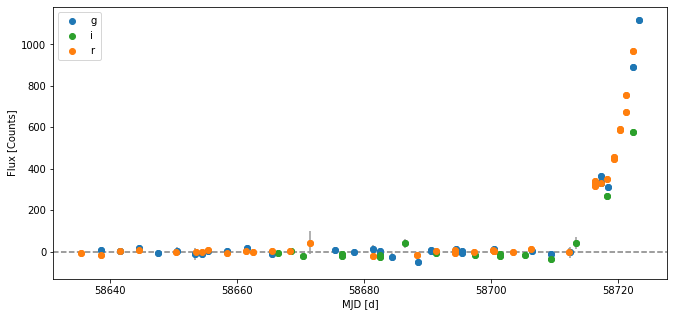

In [18]:
scalezp = 25
    
f0coef = ( 10 ** (-(lc["magzp"] - scalezp) / 2.5)
            if scalezp is not None
            else 1
        )
x, y, err = lc["obsmjd"], lc["ampl"], lc["ampl.err"]

fig = plt.figure(figsize=(11,5))
ax = fig.subplots(1)
#print(ax)

for band, band_ in [['g', "C0"], ['i', "C2"], ['r', "C1"]]:
    flag = np.asarray(lc["filter"] == ('ZTF_%s' % band), dtype="bool")
    flag = np.logical_and(flag, x < 58724)
    
    prop = {**dict(marker="o", color=band_, zorder=5, label=band)}
    ax.scatter(x[flag], (y * f0coef)[flag], **prop)
    prop["zorder"] = prop.get("zorder", 5) - 1
    del prop['label']
    ax.errorbar(
        x[flag],
        (y * f0coef)[flag],
        yerr=(f0coef*err)[flag],
        ls="None",
        ecolor="0.6",
        **prop
    )
ax.legend()
ax.axhline(0, ls="--", color="0.5")
ax.set_xlabel('MJD [d]')
ax.set_ylabel('Flux [Counts]')
fig.savefig('../paper/plots/tmp_lc_ztflc_pre_explosion.png')

Pre:  58713.4362963
Post:  58716.3888079


<ErrorbarContainer object of 3 artists>

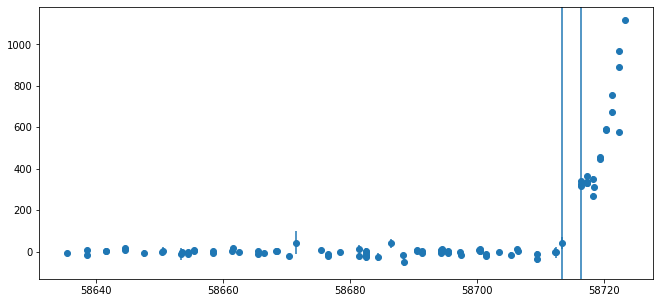

In [30]:
scalezp = 25
    
f0coef = ( 10 ** (-(lc["magzp"] - scalezp) / 2.5)
            if scalezp is not None
            else 1
        )
x, y, err = lc["obsmjd"], lc["ampl"], lc["ampl.err"]

flag = x < 58724

flux = (y * f0coef)

pre_explosion_mask = np.logical_and(flag, flux - (3*err * f0coef) <= 0)
post_explosion_mask = np.logical_and(flag, flux - (5*err * f0coef) > 0)

fig = plt.figure(figsize=(11,5))
ax = fig.subplots(1)

mjd_max_pre = x[pre_explosion_mask].max()
mjd_min_post = x[post_explosion_mask].min()
print('Pre: ', mjd_max_pre)
print('Post: ', mjd_min_post)
ax.axvline(mjd_max_pre)
ax.axvline(mjd_min_post)
ax.errorbar(x[flag], flux[flag], yerr=(err*f0coef)[flag], marker='o', ls="None")

In [37]:
import astropy.time as time
time.Time(mjd_max_pre, format='mjd').to_value('isot')

'2019-08-18T10:28:16.000'

In [38]:
time.Time(mjd_min_post, format='mjd').to_value('isot')

'2019-08-21T09:19:53.003'

In [40]:
# load atlas lc
atlas_lc = table.Table.read('../data/atlas_lc/job19862.txt', format='ascii')
atlas_lc

<Table length=777>
   ##MJD        m       dm    uJy  ...  apfit  mag5sig   Sky        Obs      
  float64    float64 float64 int64 ... float64 float64 float64     str14     
------------ ------- ------- ----- ... ------- ------- ------- --------------
58613.617713 -21.034   1.906   -14 ...  -0.415   18.55   19.56 01a58613o0713o
58613.620492  19.301   0.494    69 ...  -0.412   18.16   18.99 01a58613o0719o
58621.620834 -18.876   1.363  -102 ...  -0.428   17.63   18.26 01a58621o0040o
58623.566487  -21.15   3.169   -13 ...  -0.427   18.07   18.48 02a58623o0656o
58629.571111  22.204   4.842     5 ...   -0.42   18.78   19.87 01a58629o0684o
58629.573875 -20.488   0.884   -23 ...  -0.422   18.89   19.92 01a58629o0690o
 58629.58036 -23.227  11.333    -2 ...   -0.45   18.89   19.92 01a58629o0704o
58629.597153 -21.553   2.318    -9 ...  -0.451   19.06   20.15 01a58629o0735o
58631.535383  20.606   0.527    21 ...  -0.434   19.28   20.15 02a58631o0603o
58631.538127  -21.39   1.333   -10 ...   -0.44   19.26   20.17 02a58631o0609o
         ...     ...     ...   ... ...     ...     ...     ...            ...
59227.243379 -17.354   0.019  -416 ...  -0.402   19.52   21.11 02a59227o0105c
59227.256215 -17.459   0.023  -377 ...  -0.408   19.45   21.07 02a59227o0133c
59235.215595  16.278   2.396  1118 ...  -0.438   14.24   14.05 02a59235o0019o
59235.219252 -19.613   1.963   -52 ...  -0.417   16.69    16.5 02a59235o0027o
59235.224759 -17.176   0.492  -490 ...  -0.419    16.2   16.24 02a59235o0039o
59235.236664 -19.515    0.99   -57 ...  -0.408   17.45   17.64 02a59235o0065o
59243.212789 -19.682   1.012   -49 ...  -0.413   17.64   17.56 02a59243o0026o
59243.215988 -18.648   0.319  -126 ...  -0.419   17.97   18.12 02a59243o0033o
59243.224239  -18.47   0.234  -149 ...  -0.414   18.21   18.52 02a59243o0051o
 59243.23571 -19.041   0.485   -88 ...  -0.392    18.0   18.38 02a59243o0076o

(-50.0, 200.0)

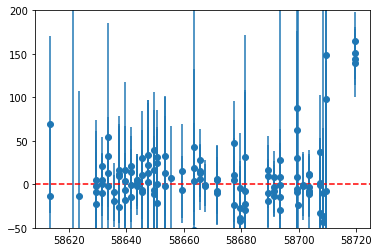

In [44]:
mjd = atlas_lc['##MJD']
idx = mjd < 58720
plt.errorbar(mjd[idx], atlas_lc['uJy'][idx], yerr=3*atlas_lc['duJy'][idx], fmt='o')
plt.axhline(y=0, ls='--', color='red')
plt.ylim((-50, 200))